In [18]:
import torch.optim as optim
from utils import *
from model import *
import config
from train import *
from scipy.stats import truncnorm
import torch


# Load weight

In [19]:
gen = Generator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)
critic = Discriminator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))

In [20]:
def generate_examples(gen, steps, root_path, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, config.Z_DIM, 1, 1)),
                                 device=config.DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            save_image(img * 0.5 + 0.5, f"../{root_path}/saved_examples/img_{i}.png")
    gen.train()

In [21]:
load_checkpoint('../../weightCelebA//generator.pth', gen, opt_gen, config.LEARNING_RATE)
generate_examples(gen, 3, root_path= 'fakeCeleba', n = 200)
load_checkpoint('../../weightCiFAR//generator.pth', gen, opt_gen, config.LEARNING_RATE)
generate_examples(gen, 3, root_path= 'fakeCIFAR', n = 200)

=> Loading checkpoint
=> Loading checkpoint


In [22]:
import cv2
# Load image in LAB format
lab_img = cv2.imread('../fakeCeleba/saved_examples/img_1.png', cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)

# Convert LAB image to RGB
rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
print(type(rgb_img))
# plt.imshow(rgb_img)

<class 'numpy.ndarray'>


In [23]:
steps = [0,1,2,3,4]
alpha = 1

In [24]:
# Generate 1 anh duy nhat 
with torch.no_grad():
    generated_images = []
    noise = torch.tensor(truncnorm.rvs(-0.7, 0.7, size=(1, config.Z_DIM, 1, 1)),
                            device=config.DEVICE, dtype=torch.float32)
    img = gen(noise, alpha, steps[3])
    print(img.shape)
    generated_images.append(img)
    generated_images = torch.cat(generated_images, dim = 0)
    print(generated_images.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [25]:
# Load CIFAR (real data)    
real_loader, datasets = get_loader_CIFAR(4 * 2 ** steps[3])
real_C, labels = next(iter(real_loader))

Files already downloaded and verified


In [26]:
# Load CelebA (real data)    
real_loader, datasets = get_loader(4 * 2 ** steps[3], r"../../Celeba_dataset/img_align_celeba")
real_Ce, labels = next(iter(real_loader))

In [27]:
from train import *
# Load generated images CelebA (fake data)
fake_loader, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCeleba")
fake_CE, labels = next(iter(fake_loader))

In [28]:
from train import *
# Load generated images CelebA (fake data)
fake_loader, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCIFAR")
fake_C, labels = next(iter(fake_loader))

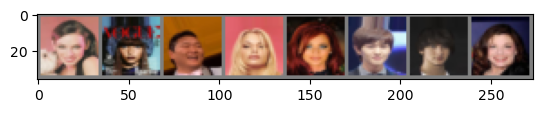

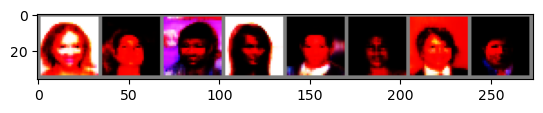

In [29]:
imshow(torchvision.utils.make_grid(real_Ce[:8]))
imshow(torchvision.utils.make_grid(fake_CE[:8]))

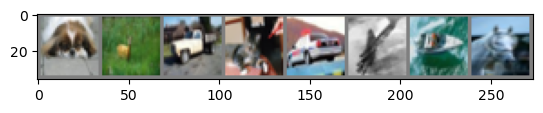

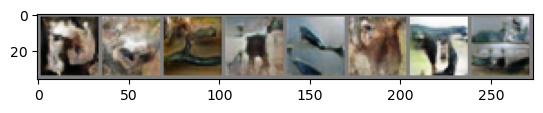

In [30]:
imshow(torchvision.utils.make_grid(real_C[:8]))
imshow(torchvision.utils.make_grid(fake_C[:8]))

In [42]:
print("Calculating Inception Score for CelebA dataset: ")
means_Ce, std_Ce  = inception_score(real_Ce, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_Ce, means_Ce)
means_fake, std_fake = inception_score(fake_CE, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_fake, means_fake)

Calculating Inception Score for CelebA dataset: 
0.17332079899970093 1.3681346534163756
0.20197980345561314 1.3830696970514769


In [43]:
print("Calculating Inception Score for CelebA dataset: ")
fid_score(means_Ce, means_fake, std_Ce, std_fake)

Calculating Inception Score for CelebA dataset: 


1.9465197577573088

In [44]:
print("Calculating Inception Score for CIFAR10 dataset: ")
means_C, std_C  = inception_score(real_C, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_Ce, means_Ce)
means_fake, std_fake  = inception_score(fake_C, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_fake, means_fake)

Calculating Inception Score for CIFAR10 dataset: 
0.17332079899970093 1.3681346534163756
0.18616388182219018 1.5417603814837826


In [45]:
fid_score(means_C, means_fake, std_C, std_fake)

2.2664535651709103